# Setup

In [1]:
# import your standard packages
%run ../pkgs.py

# import your local functions
sys.path.insert(1, '../')
from local_functions import *

# make sure the figures plot inline rather than at the end
%matplotlib inline

Default libraries loaded.


# Parameters and Paths

In [2]:
inpath = "/tigress/GEOCLIM/LRGROUP/shared_data/woa18/"
outfn = '../../data/woa_processed.nc'

# total
lat_bounds = [-1.5, 33]
lon_bounds = [48.5, 102.5]

# regional 
bounds_wAS = [51.125,66,12.5,28]
bounds_eAS = [66,79,3,28]
bounds_wBoB = [79,87,2,28]
bounds_eBoB = [87,103,0,28]

# Get Data

In [3]:
for tt in tqdm(range(1,13)):
     
    if tt < 10:
        t='0'+str(tt)
    else:
        t=str(tt)
        
    if tt == 1:
        data=xr.open_dataset(inpath+"temp/1deg/monthly/woa18_decav_t"+t+"_01.nc", decode_times=False)
        
        DEPTH = data.depth
        
        
        TEMP = np.full([12,data["t_an"].shape[1],data["t_an"].shape[2],data["t_an"].shape[3]],np.nan)
        DOXY = np.full([12,data["t_an"].shape[1],data["t_an"].shape[2],data["t_an"].shape[3]],np.nan)
        PSAL = np.full([12,data["t_an"].shape[1],data["t_an"].shape[2],data["t_an"].shape[3]],np.nan)
        NITRATE = np.full([12,data["t_an"].shape[1],data["t_an"].shape[2],data["t_an"].shape[3]],np.nan)
        PHOSPHATE = np.full([12,data["t_an"].shape[1],data["t_an"].shape[2],data["t_an"].shape[3]],np.nan)
       
        
    # TEMP
    data=xr.open_dataset(inpath+"temp/1deg/monthly/woa18_decav_t"+t+"_01.nc", decode_times=False)
    TEMP[tt-1,:,:,:] = np.array(data["t_an"][0,:,:,:])
    
    # PSAL
    data=xr.open_dataset(inpath+"salt/1deg/monthly/woa18_decav_s"+t+"_01.nc", decode_times=False)
    PSAL[tt-1,:,:,:] = np.array(data["s_an"][0,:,:,:])
    
    # DOXY
    data=xr.open_dataset(inpath+"oxygen/monthly/woa18_all_o"+t+"_01.nc", decode_times=False)
    DOXY[tt-1,:,:,:] = np.array(data["o_an"][0,:,:,:])
    
    # Nitrate
    data=xr.open_dataset(inpath+"nitrate/monthly/woa18_all_n"+t+"_01.nc", decode_times=False)
    NITRATE[tt-1,:43,:,:] = np.array(data["n_an"][0,:,:,:])
    
    # Phosphate
    data=xr.open_dataset(inpath+"phosphate/monthly/woa18_all_p"+t+"_01.nc", decode_times=False)
    PHOSPHATE[tt-1,:43,:,:] = np.array(data["p_an"][0,:,:,:])
    
# depth to pressure
LAT = np.array(data.lat)
LON = np.array(data.lon)

# PRES = np.full([len(DEPTH),len(LAT),len(LON)],np.nan)

# for ii,tmplat in zip(range(len(LAT)),LAT):
#     for jj in range(len(lon)):
#         PRES[:,ii,jj]=sw.eos80.pres(DEPTH, [tmplat for i in range(len(DEPTH))])


100%|██████████| 12/12 [00:09<00:00,  1.37it/s]


# Subset

In [4]:
ds_full = xr.Dataset(coords={'month': np.arange(1,13),
                        'depth': DEPTH,
                        'lon': LON,
                        'lat': LAT})

coords = [np.arange(1,13),DEPTH,LAT,LON]
dims = ['month','depth','lat','lon']

# add to dataset
ds_full['temp'] = xr.DataArray(TEMP,dims = dims,coords = coords)
ds_full['psal'] = xr.DataArray(PSAL,dims = dims,coords = coords)
ds_full['doxy'] = xr.DataArray(DOXY,dims = dims,coords = coords)
ds_full['nitrate'] = xr.DataArray(NITRATE,dims = dims,coords = coords)
ds_full['phosphate'] = xr.DataArray(PHOSPHATE,dims = dims,coords = coords)


# subset
lat_slice = slice(lat_bounds[0], lat_bounds[1])
lon_slice = slice(lon_bounds[0], lon_bounds[1])

ds_full = ds_full.sel(lat = lat_slice, lon = lon_slice)
ds_full

<xarray.Dataset>
Dimensions:    (depth: 57, lat: 35, lon: 55, month: 12)
Coordinates:
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * depth      (depth) float32 0.0 5.0 10.0 15.0 ... 1350.0 1400.0 1450.0 1500.0
  * lon        (lon) float32 48.5 49.5 50.5 51.5 52.5 ... 99.5 100.5 101.5 102.5
  * lat        (lat) float32 -1.5 -0.5 0.5 1.5 2.5 ... 28.5 29.5 30.5 31.5 32.5
Data variables:
    temp       (month, depth, lat, lon) float64 27.04 27.16 27.28 ... nan nan
    psal       (month, depth, lat, lon) float64 35.32 35.32 35.32 ... nan nan
    doxy       (month, depth, lat, lon) float64 208.9 209.1 208.3 ... nan nan
    nitrate    (month, depth, lat, lon) float64 0.7416 0.4686 0.202 ... nan nan
    phosphate  (month, depth, lat, lon) float64 0.1886 0.2047 0.2121 ... nan nan

# Interpolate to Standard Pressure Levels

In [5]:
PRES_i = np.array(ds_full.depth)

n = ds_full.lat.shape[0]
m = ds_full.lon.shape[0]
t = 12
d = ds_full.depth.shape[0]
with tqdm(total=n * m * t) as pbar:
    for tt in range(12):
        
        if tt == 0:
            TEMP_i = np.zeros((12,PRES_i.shape[0],n,m))*np.nan
            DOXY_i = np.zeros((12,PRES_i.shape[0],n,m))*np.nan
            PSAL_i = np.zeros((12,PRES_i.shape[0],n,m))*np.nan
            NITRATE_i = np.zeros((12,PRES_i.shape[0],n,m))*np.nan
            PHOSPHATE_i = np.zeros((12,PRES_i.shape[0],n,m))*np.nan
                    
        for ii,lat in zip(range(n),ds_full.lat):
            for jj in range(m):

                # conversion [m] -> [dbar]:
#                 pres=sw.eos80.pres(ds_full.depth, [lat for i in range(d)])
                pres = gsw.p_from_z(-1*ds_full.depth, [lat for i in range(d)])

                # temp,psal,doxy selection
                temp,psal,doxy = ds_full.temp[tt,:,ii,jj],ds_full.psal[tt,:,ii,jj],ds_full.doxy[tt,:,ii,jj]
                nitrate,phosphate = ds_full.nitrate[tt,:,ii,jj],ds_full.phosphate[tt,:,ii,jj]

                # interpolation
                ft = sp.interp1d(pres,temp,bounds_error=False,fill_value=np.nan)
                TEMP_i[tt,:,ii,jj] = ft(PRES_i)
                    
                fo = sp.interp1d(pres,doxy,bounds_error=False,fill_value=np.nan)
                DOXY_i[tt,:,ii,jj] = fo(PRES_i)
                
                fs = sp.interp1d(pres,psal,bounds_error=False,fill_value=np.nan)
                PSAL_i[tt,:,ii,jj] = fs(PRES_i)
                
                fn = sp.interp1d(pres,nitrate,bounds_error=False,fill_value=np.nan)
                NITRATE_i[tt,:,ii,jj] = fn(PRES_i)
                
                fp = sp.interp1d(pres,phosphate,bounds_error=False,fill_value=np.nan)
                PHOSPHATE_i[tt,:,ii,jj] = fp(PRES_i)
                
                pbar.update(1)
            
            
ds_out=xr.Dataset(coords={'month': np.arange(1,13),
                        'pres': PRES_i,
                        'lon': ds_full.lon,
                        'lat': ds_full.lat})
# add to dataset
ds_out['temp'] = xr.DataArray(TEMP_i,dims = ['month','pres','lat','lon'],coords =[np.arange(1,13),PRES_i,ds_full.lat,ds_full.lon])
ds_out['psal'] = xr.DataArray(PSAL_i,dims = ['month','pres','lat','lon'],coords =[np.arange(1,13),PRES_i,ds_full.lat,ds_full.lon])
ds_out['doxy'] = xr.DataArray(DOXY_i,dims = ['month','pres','lat','lon'],coords =[np.arange(1,13),PRES_i,ds_full.lat,ds_full.lon])
ds_out['nitrate'] = xr.DataArray(NITRATE_i,dims = ['month','pres','lat','lon'],coords =[np.arange(1,13),PRES_i,ds_full.lat,ds_full.lon])
ds_out['phosphate'] = xr.DataArray(PHOSPHATE_i,dims = ['month','pres','lat','lon'],coords =[np.arange(1,13),PRES_i,ds_full.lat,ds_full.lon])
ds_out         

100%|██████████| 23100/23100 [01:50<00:00, 208.17it/s]


<xarray.Dataset>
Dimensions:    (lat: 35, lon: 55, month: 12, pres: 57)
Coordinates:
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * pres       (pres) float32 0.0 5.0 10.0 15.0 ... 1350.0 1400.0 1450.0 1500.0
  * lon        (lon) float32 48.5 49.5 50.5 51.5 52.5 ... 99.5 100.5 101.5 102.5
  * lat        (lat) float32 -1.5 -0.5 0.5 1.5 2.5 ... 28.5 29.5 30.5 31.5 32.5
Data variables:
    temp       (month, pres, lat, lon) float64 27.04 27.16 27.28 ... nan nan nan
    psal       (month, pres, lat, lon) float64 35.32 35.32 35.32 ... nan nan nan
    doxy       (month, pres, lat, lon) float64 208.9 209.1 208.3 ... nan nan nan
    nitrate    (month, pres, lat, lon) float64 0.7416 0.4686 0.202 ... nan nan
    phosphate  (month, pres, lat, lon) float64 0.1886 0.2047 0.2121 ... nan nan

In [6]:
ds_out

<xarray.Dataset>
Dimensions:    (lat: 35, lon: 55, month: 12, pres: 57)
Coordinates:
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * pres       (pres) float32 0.0 5.0 10.0 15.0 ... 1350.0 1400.0 1450.0 1500.0
  * lon        (lon) float32 48.5 49.5 50.5 51.5 52.5 ... 99.5 100.5 101.5 102.5
  * lat        (lat) float32 -1.5 -0.5 0.5 1.5 2.5 ... 28.5 29.5 30.5 31.5 32.5
Data variables:
    temp       (month, pres, lat, lon) float64 27.04 27.16 27.28 ... nan nan nan
    psal       (month, pres, lat, lon) float64 35.32 35.32 35.32 ... nan nan nan
    doxy       (month, pres, lat, lon) float64 208.9 209.1 208.3 ... nan nan nan
    nitrate    (month, pres, lat, lon) float64 0.7416 0.4686 0.202 ... nan nan
    phosphate  (month, pres, lat, lon) float64 0.1886 0.2047 0.2121 ... nan nan

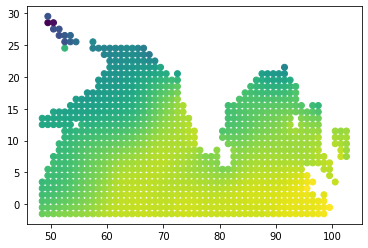

In [7]:
xx,yy = np.meshgrid(ds_out.lon,ds_out.lat)
plt.scatter(xx.flatten(),yy.flatten(), c = np.array(ds_out.temp[0,0,:,:]).flatten())

<xarray.Dataset>
Dimensions:    (lat: 35, lon: 55, month: 12, pres: 57)
Coordinates:
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * pres       (pres) float32 0.0 5.0 10.0 15.0 ... 1350.0 1400.0 1450.0 1500.0
  * lon        (lon) float32 48.5 49.5 50.5 51.5 52.5 ... 99.5 100.5 101.5 102.5
  * lat        (lat) float32 -1.5 -0.5 0.5 1.5 2.5 ... 28.5 29.5 30.5 31.5 32.5
Data variables:
    temp       (month, pres, lat, lon) float64 27.04 27.16 27.28 ... nan nan nan
    psal       (month, pres, lat, lon) float64 35.32 35.32 35.32 ... nan nan nan
    doxy       (month, pres, lat, lon) float64 208.9 209.1 208.3 ... nan nan nan
    nitrate    (month, pres, lat, lon) float64 0.7416 0.4686 0.202 ... nan nan
    phosphate  (month, pres, lat, lon) float64 0.1886 0.2047 0.2121 ... nan nan
    sal        (month, pres, lat, lon) float64 35.32 35.32 35.32 ... nan nan nan

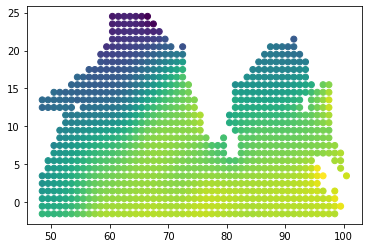

In [8]:
temp = ds_out.temp.where(~((yy>23) & (yy<32) & (xx>45) & (xx<60)))
sal = ds_out.psal.where(~((yy>23) & (yy<32) & (xx>45) & (xx<60)))
doxy = ds_out.doxy.where(~((yy>23) & (yy<32) & (xx>45) & (xx<60)))
nitrate = ds_out.nitrate.where(~((yy>23) & (yy<32) & (xx>45) & (xx<60)))
phosphate = ds_out.phosphate.where(~((yy>23) & (yy<32) & (xx>45) & (xx<60)))

temp = temp.where(~((yy>6) & (yy<15) & (xx>100) & (xx<110)))
sal = sal.where(~((yy>6) & (yy<15) & (xx>100) & (xx<110)))
doxy = doxy.where(~((yy>6) & (yy<15) & (xx>100) & (xx<110)))
nitrate = nitrate.where(~((yy>6) & (yy<15) & (xx>100) & (xx<110)))
phosphate = phosphate.where(~((yy>6) & (yy<15) & (xx>100) & (xx<110)))

xx,yy = np.meshgrid(temp.lon,temp.lat)
plt.scatter(xx.flatten(),yy.flatten(), c = np.array(temp[1,0,:,:]).flatten())

lat = temp.lat
lon = temp.lon
pres = temp.pres

# add to dataset
ds_out['temp'] = xr.DataArray(temp,dims = ['month','pres','lat','lon'],coords =[np.arange(1,13),pres,lat,lon])
ds_out['sal'] = xr.DataArray(sal,dims = ['month','pres','lat','lon'],coords =[np.arange(1,13),pres,lat,lon])
ds_out['doxy'] = xr.DataArray(doxy,dims = ['month','pres','lat','lon'],coords =[np.arange(1,13),pres,lat,lon])
ds_out['nitrate'] = xr.DataArray(nitrate,dims = ['month','pres','lat','lon'],coords =[np.arange(1,13),pres,lat,lon])
ds_out['phosphate'] = xr.DataArray(phosphate,dims = ['month','pres','lat','lon'],coords =[np.arange(1,13),pres,lat,lon])
ds_out   

# Make sure there aren't any negative concentration values

In [9]:
tmp = np.array(ds_out.doxy)
np.nansum(tmp[tmp <= 0])

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less_equal
  


0.0

In [10]:
# set negative oxygen values to nan
ds_out['doxy'] = ds_out.doxy.where(ds_out.doxy >= 0)
ds_out['nitrate'] = ds_out.nitrate.where(ds_out.nitrate >= 0)
ds_out['phosphate'] = ds_out.phosphate.where(ds_out.phosphate >= 0)

# Find Water Column Averages

In [11]:
# total mean
ind = (ds_out.pres >= 40) & (ds_out.pres <= 200)
doxy_40_200 = np.nanmean(ds_out.doxy[:,ind,:,:],1)
temp_40_200 = np.nanmean(ds_out.temp[:,ind,:,:],1)
psal_40_200 = np.nanmean(ds_out.psal[:,ind,:,:],1)
nitrate_40_200 = np.nanmean(ds_out.nitrate[:,ind,:,:],1)
phosphate_40_200 = np.nanmean(ds_out.phosphate[:,ind,:,:],1)

ind = (ds_out.pres >= 50) & (ds_out.pres <= 200)
doxy_50_200 = np.nanmean(ds_out.doxy[:,ind,:,:],1)
temp_50_200 = np.nanmean(ds_out.temp[:,ind,:,:],1)
psal_50_200 = np.nanmean(ds_out.psal[:,ind,:,:],1)
nitrate_50_200 = np.nanmean(ds_out.nitrate[:,ind,:,:],1)
phosphate_50_200 = np.nanmean(ds_out.phosphate[:,ind,:,:],1)

ind = (ds_out.pres >= 50) & (ds_out.pres <= 225)
doxy_50_225 = np.nanmean(ds_out.doxy[:,ind,:,:],1)
temp_50_225 = np.nanmean(ds_out.temp[:,ind,:,:],1)
psal_50_225 = np.nanmean(ds_out.psal[:,ind,:,:],1)
nitrate_50_225 = np.nanmean(ds_out.nitrate[:,ind,:,:],1)
phosphate_50_225 = np.nanmean(ds_out.phosphate[:,ind,:,:],1)

# annual mean
ind = (ds_out.pres >= 40) & (ds_out.pres <= 200)
doxy_40_200_ann_mean = np.nanmean(np.nanmean(ds_out.doxy,0)[ind,:,:],0)
temp_40_200_ann_mean  = np.nanmean(np.nanmean(ds_out.temp,0)[ind,:,:],0)
psal_40_200_ann_mean  = np.nanmean(np.nanmean(ds_out.psal,0)[ind,:,:],0)
nitrate_40_200_ann_mean  = np.nanmean(np.nanmean(ds_out.nitrate,0)[ind,:,:],0)
phosphate_40_200_ann_mean  = np.nanmean(np.nanmean(ds_out.phosphate,0)[ind,:,:],0)

ind = (ds_out.pres >= 50) & (ds_out.pres <= 200)
doxy_50_200_ann_mean  = np.nanmean(np.nanmean(ds_out.doxy,0)[ind,:,:],0)
temp_50_200_ann_mean  = np.nanmean(np.nanmean(ds_out.temp,0)[ind,:,:],0)
psal_50_200_ann_mean  = np.nanmean(np.nanmean(ds_out.psal,0)[ind,:,:],0)
nitrate_50_200_ann_mean  = np.nanmean(np.nanmean(ds_out.nitrate,0)[ind,:,:],0)
phosphate_50_200_ann_mean  = np.nanmean(np.nanmean(ds_out.phosphate,0)[ind,:,:],0)

ind = (ds_out.pres >= 50) & (ds_out.pres <= 225)
doxy_50_225_ann_mean  = np.nanmean(np.nanmean(ds_out.doxy,0)[ind,:,:],0)
temp_50_225_ann_mean  = np.nanmean(np.nanmean(ds_out.temp,0)[ind,:,:],0)
psal_50_225_ann_mean  = np.nanmean(np.nanmean(ds_out.psal,0)[ind,:,:],0)
nitrate_50_225_ann_mean  = np.nanmean(np.nanmean(ds_out.nitrate,0)[ind,:,:],0)
phosphate_50_225_ann_mean  = np.nanmean(np.nanmean(ds_out.phosphate,0)[ind,:,:],0)

# mean anomaly to 200dbar
ind = (ds_out.pres >= 40) & (ds_out.pres <= 200)
doxy_40_200_anom = np.nanmean(ds_out.doxy[:,ind,:,:] - np.nanmean(ds_out.doxy,0)[ind,:,:],1)
temp_40_200_anom = np.nanmean(ds_out.temp[:,ind,:,:] - np.nanmean(ds_out.temp,0)[ind,:,:],1)
psal_40_200_anom = np.nanmean(ds_out.psal[:,ind,:,:] - np.nanmean(ds_out.psal,0)[ind,:,:],1)
nitrate_40_200_anom = np.nanmean(ds_out.nitrate[:,ind,:,:] - np.nanmean(ds_out.nitrate,0)[ind,:,:],1)
phosphate_40_200_anom = np.nanmean(ds_out.phosphate[:,ind,:,:] - np.nanmean(ds_out.phosphate,0)[ind,:,:],1)

ind = (ds_out.pres >= 50) & (ds_out.pres <= 200)
doxy_50_200_anom = np.nanmean(ds_out.doxy[:,ind,:,:] - np.nanmean(ds_out.doxy,0)[ind,:,:],1)
temp_50_200_anom = np.nanmean(ds_out.temp[:,ind,:,:] - np.nanmean(ds_out.temp,0)[ind,:,:],1)
psal_50_200_anom = np.nanmean(ds_out.psal[:,ind,:,:] - np.nanmean(ds_out.psal,0)[ind,:,:],1)
nitrate_50_200_anom = np.nanmean(ds_out.nitrate[:,ind,:,:] - np.nanmean(ds_out.nitrate,0)[ind,:,:],1)
phosphate_50_200_anom = np.nanmean(ds_out.phosphate[:,ind,:,:] - np.nanmean(ds_out.phosphate,0)[ind,:,:],1)

ind = (ds_out.pres >= 50) & (ds_out.pres <= 225)
doxy_50_225_anom = np.nanmean(ds_out.doxy[:,ind,:,:] - np.nanmean(ds_out.doxy,0)[ind,:,:],1)
temp_50_225_anom = np.nanmean(ds_out.temp[:,ind,:,:] - np.nanmean(ds_out.temp,0)[ind,:,:],1)
psal_50_225_anom = np.nanmean(ds_out.psal[:,ind,:,:] - np.nanmean(ds_out.psal,0)[ind,:,:],1)
nitrate_50_225_anom = np.nanmean(ds_out.nitrate[:,ind,:,:] - np.nanmean(ds_out.nitrate,0)[ind,:,:],1)
phosphate_50_225_anom = np.nanmean(ds_out.phosphate[:,ind,:,:] - np.nanmean(ds_out.phosphate,0)[ind,:,:],1)


/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is adde

In [12]:
# add to dataset

#------------------------------ profiles -------------------------------------#
coords = [ds_out.month,ds_out.lat,ds_out.lon]
dims = ['month','lat', 'lon']

ds_out['temp_40_200'] = xr.DataArray(temp_40_200,dims = dims,coords = coords)
ds_out['doxy_40_200'] = xr.DataArray(doxy_40_200,dims = dims,coords = coords)
ds_out['psal_40_200'] = xr.DataArray(psal_40_200,dims = dims,coords = coords)
ds_out['nitrate_40_200'] = xr.DataArray(nitrate_40_200,dims = dims,coords = coords)
ds_out['phosphate_40_200'] = xr.DataArray(phosphate_40_200,dims = dims,coords = coords)

ds_out['temp_50_200'] = xr.DataArray(temp_50_200,dims = dims,coords = coords)
ds_out['doxy_50_200'] = xr.DataArray(doxy_50_200,dims = dims,coords = coords)
ds_out['psal_50_200'] = xr.DataArray(psal_50_200,dims = dims,coords = coords)
ds_out['nitrate_50_200'] = xr.DataArray(nitrate_50_200,dims = dims,coords = coords)
ds_out['phosphate_50_200'] = xr.DataArray(phosphate_50_200,dims = dims,coords = coords)

ds_out['temp_50_225'] = xr.DataArray(temp_50_225,dims = dims,coords = coords)
ds_out['doxy_50_225'] = xr.DataArray(doxy_50_225,dims = dims,coords = coords)
ds_out['psal_50_225'] = xr.DataArray(psal_50_225,dims = dims,coords = coords)
ds_out['nitrate_50_225'] = xr.DataArray(nitrate_50_225,dims = dims,coords = coords)
ds_out['phosphate_50_225'] = xr.DataArray(phosphate_50_225,dims = dims,coords = coords)

#------------------------------ annual mean -----------------------------------#
coords = [ds_out.lat,ds_out.lon]
dims = ['lat', 'lon']

ds_out['temp_40_200_ann_mean'] = xr.DataArray(temp_40_200_ann_mean,dims = dims,coords = coords)
ds_out['doxy_40_200_ann_mean'] = xr.DataArray(doxy_40_200_ann_mean,dims = dims,coords = coords)
ds_out['psal_40_200_ann_mean'] = xr.DataArray(psal_40_200_ann_mean,dims = dims,coords = coords)
ds_out['nitrate_40_200_ann_mean'] = xr.DataArray(nitrate_40_200_ann_mean,dims = dims,coords = coords)
ds_out['phosphate_40_200_ann_mean'] = xr.DataArray(phosphate_40_200_ann_mean,dims = dims,coords = coords)

ds_out['temp_50_200_ann_mean'] = xr.DataArray(temp_50_200_ann_mean,dims = dims,coords = coords)
ds_out['doxy_50_200_ann_mean'] = xr.DataArray(doxy_50_200_ann_mean,dims = dims,coords = coords)
ds_out['psal_50_200_ann_mean'] = xr.DataArray(psal_50_200_ann_mean,dims = dims,coords = coords)
ds_out['nitrate_50_200_ann_mean'] = xr.DataArray(nitrate_50_200_ann_mean,dims = dims,coords = coords)
ds_out['phosphate_50_200_ann_mean'] = xr.DataArray(phosphate_50_200_ann_mean,dims = dims,coords = coords)

ds_out['temp_50_225_ann_mean'] = xr.DataArray(temp_50_225_ann_mean,dims = dims,coords = coords)
ds_out['doxy_50_225_ann_mean'] = xr.DataArray(doxy_50_225_ann_mean,dims = dims,coords = coords)
ds_out['psal_50_225_ann_mean'] = xr.DataArray(psal_50_225_ann_mean,dims = dims,coords = coords)
ds_out['nitrate_50_225_ann_mean'] = xr.DataArray(nitrate_50_225_ann_mean,dims = dims,coords = coords)
ds_out['phosphate_50_225_ann_mean'] = xr.DataArray(phosphate_50_225_ann_mean,dims = dims,coords = coords)

#---------------------------- monthly anomaly ---------------------------------#
coords = [ds_out.month,ds_out.lat,ds_out.lon]
dims = ['month','lat', 'lon']

ds_out['temp_40_200_anom'] = xr.DataArray(temp_40_200_anom,dims = dims,coords = coords)
ds_out['doxy_40_200_anom'] = xr.DataArray(doxy_40_200_anom,dims = dims,coords = coords)
ds_out['psal_40_200_anom'] = xr.DataArray(psal_40_200_anom,dims = dims,coords = coords)
ds_out['nitrate_40_200_anom'] = xr.DataArray(nitrate_40_200_anom,dims = dims,coords = coords)
ds_out['phosphate_40_200_anom'] = xr.DataArray(phosphate_40_200_anom,dims = dims,coords = coords)

ds_out['temp_50_200_anom'] = xr.DataArray(temp_50_200_anom,dims = dims,coords = coords)
ds_out['doxy_50_200_anom'] = xr.DataArray(doxy_50_200_anom,dims = dims,coords = coords)
ds_out['psal_50_200_anom'] = xr.DataArray(psal_50_200_anom,dims = dims,coords = coords)
ds_out['nitrate_50_200_anom'] = xr.DataArray(nitrate_50_200_anom,dims = dims,coords = coords)
ds_out['phosphate_50_200_anom'] = xr.DataArray(phosphate_50_200_anom,dims = dims,coords = coords)

ds_out['temp_50_225_anom'] = xr.DataArray(temp_50_225_anom,dims = dims,coords = coords)
ds_out['doxy_50_225_anom'] = xr.DataArray(doxy_50_225_anom,dims = dims,coords = coords)
ds_out['psal_50_225_anom'] = xr.DataArray(psal_50_225_anom,dims = dims,coords = coords)
ds_out['nitrate_50_225_anom'] = xr.DataArray(nitrate_50_225_anom,dims = dims,coords = coords)
ds_out['phosphate_50_225_anom'] = xr.DataArray(phosphate_50_225_anom,dims = dims,coords = coords)

ds_out

<xarray.Dataset>
Dimensions:                    (lat: 35, lon: 55, month: 12, pres: 57)
Coordinates:
  * month                      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * pres                       (pres) float32 0.0 5.0 10.0 ... 1450.0 1500.0
  * lon                        (lon) float32 48.5 49.5 50.5 ... 101.5 102.5
  * lat                        (lat) float32 -1.5 -0.5 0.5 ... 30.5 31.5 32.5
Data variables:
    temp                       (month, pres, lat, lon) float64 27.04 ... nan
    psal                       (month, pres, lat, lon) float64 35.32 ... nan
    doxy                       (month, pres, lat, lon) float64 208.9 ... nan
    nitrate                    (month, pres, lat, lon) float64 0.7416 ... nan
    phosphate                  (month, pres, lat, lon) float64 0.1886 ... nan
    sal                        (month, pres, lat, lon) float64 35.32 ... nan
    temp_40_200                (month, lat, lon) float64 22.35 22.06 ... nan nan
    doxy_40_200                (mon

# Find Coastal Mask

In [13]:
# wide shelf
xx,yy = np.meshgrid(np.array(ds_out.lon),np.array(ds_out.lat))

xx,yy = xx.flatten(), yy.flatten()

mask = mask_coast(xx,yy,[lon_bounds[0],lon_bounds[1],lat_bounds[0],lat_bounds[1]])
mask.shape
mask_xx = xx[mask]
mask_yy = yy[mask]

# narrow shelf
masks = mask_coast_shelf(xx,yy,[lon_bounds[0],lon_bounds[1],lat_bounds[0],lat_bounds[1]])

mask_xxs = xx[masks]
mask_yys = yy[masks]

# add to dataset
ds_out['coastal_mask'] = xr.DataArray(mask,dims = ['coastal_loc'],coords =[np.arange(len(mask))])
ds_out['coastal_mask_xx'] = xr.DataArray(mask_xx,dims = ['coastal_pos'],coords =[np.arange(len(mask[mask]))])
ds_out['coastal_mask_yy'] = xr.DataArray(mask_yy,dims = ['coastal_pos'],coords =[np.arange(len(mask[mask]))])
ds_out['coastal_masks'] = xr.DataArray(masks,dims = ['coastal_locs'],coords =[np.arange(len(masks))])
ds_out['coastal_mask_xxs'] = xr.DataArray(mask_xxs,dims = ['coastal_poss'],coords =[np.arange(len(masks[masks]))])
ds_out['coastal_mask_yys'] = xr.DataArray(mask_yys,dims = ['coastal_poss'],coords =[np.arange(len(masks[masks]))])


ds_out['coastal_mask_bounds'] = xr.DataArray([lon_bounds[0],lon_bounds[1],lat_bounds[0],lat_bounds[1]],
                                             dims = ['lonmin,lonmax,latmin,latmax'],
                                             coords =[np.arange(4)])

# ds_out

# Find Coastal Mask Data

# 50-200

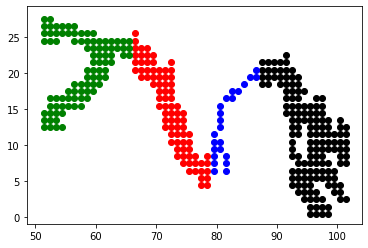

In [14]:
#----------------- Western Arabian Sea ---------------------#

lat_slice_wAS = slice(bounds_wAS[2],bounds_wAS[3]) 
lon_slice_wAS = slice(bounds_wAS[0],bounds_wAS[1]) 

#subset gridded data
temp_wAS = ds_out.temp_50_200.sel(lat = lat_slice_wAS, lon = lon_slice_wAS)
doxy_wAS = ds_out.doxy_50_200.sel(lat = lat_slice_wAS, lon = lon_slice_wAS)
nitrate_wAS = ds_out.nitrate_50_200.sel(lat = lat_slice_wAS, lon = lon_slice_wAS)
phosphate_wAS = ds_out.phosphate_50_200.sel(lat = lat_slice_wAS, lon = lon_slice_wAS)

# convert to coastal
xx,yy = np.meshgrid(np.array(temp_wAS.lon),np.array(temp_wAS.lat))
xx_wAS = xx.flatten()
yy_wAS = yy.flatten()

mask_wAS = mask_coast(xx_wAS,yy_wAS,np.array(ds_out.coastal_mask_bounds))
temp_wAS = temp_wAS.stack(allpoints=['lat','lon'])[:,mask_wAS]
doxy_wAS = doxy_wAS.stack(allpoints=['lat','lon'])[:,mask_wAS]
nitrate_wAS = nitrate_wAS.stack(allpoints=['lat','lon'])[:,mask_wAS]
phosphate_wAS = phosphate_wAS.stack(allpoints=['lat','lon'])[:,mask_wAS]
xx_wAS = xx_wAS[mask_wAS]
yy_wAS = yy_wAS[mask_wAS]

mon_wAS = np.full(temp_wAS.shape,np.nan)
lat_wAS = np.full(temp_wAS.shape,np.nan)
lon_wAS = np.full(temp_wAS.shape,np.nan)
for tt in range(1,13):
    mon_wAS[tt-1,:] = np.ones([1,temp_wAS.shape[1]])*tt
    lat_wAS[tt-1,:] = yy_wAS
    lon_wAS[tt-1,:] = xx_wAS
    
temp_wAS = np.array(temp_wAS).flatten()
doxy_wAS = np.array(doxy_wAS).flatten()
nitrate_wAS = np.array(nitrate_wAS).flatten()
phosphate_wAS = np.array(phosphate_wAS).flatten()
mon_wAS = np.array(mon_wAS).flatten()
lat_wAS = np.array(lat_wAS).flatten()
lon_wAS = np.array(lon_wAS).flatten()

# mon_wAS = mon_wAS[~np.isnan(temp_wAS)]
# lat_wAS = lat_wAS[~np.isnan(temp_wAS)]
# lon_wAS = lon_wAS[~np.isnan(temp_wAS)]
# doxy_wAS = doxy_wAS[~np.isnan(temp_wAS)]
# nitrate_wAS = nitrate_wAS[~np.isnan(temp_wAS)]
# phosphate_wAS = phosphate_wAS[~np.isnan(temp_wAS)]
# temp_wAS = temp_wAS[~np.isnan(temp_wAS)]


#----------------- Eastern Arabian Sea ---------------------#

lat_slice_eAS = slice(bounds_eAS[2],bounds_eAS[3]) 
lon_slice_eAS = slice(bounds_eAS[0],bounds_eAS[1]) 

#subset gridded data
temp_eAS = ds_out.temp_50_200.sel(lat = lat_slice_eAS, lon = lon_slice_eAS)
doxy_eAS = ds_out.doxy_50_200.sel(lat = lat_slice_eAS, lon = lon_slice_eAS)
nitrate_eAS = ds_out.nitrate_50_200.sel(lat = lat_slice_eAS, lon = lon_slice_eAS)
phosphate_eAS = ds_out.phosphate_50_200.sel(lat = lat_slice_eAS, lon = lon_slice_eAS)

# convert to coastal
xx,yy = np.meshgrid(np.array(temp_eAS.lon),np.array(temp_eAS.lat))
xx_eAS = xx.flatten()
yy_eAS = yy.flatten()

mask_eAS = mask_coast(xx_eAS,yy_eAS,np.array(ds_out.coastal_mask_bounds))
temp_eAS = temp_eAS.stack(allpoints=['lat','lon'])[:,mask_eAS]
doxy_eAS = doxy_eAS.stack(allpoints=['lat','lon'])[:,mask_eAS]
nitrate_eAS = nitrate_eAS.stack(allpoints=['lat','lon'])[:,mask_eAS]
phosphate_eAS = phosphate_eAS.stack(allpoints=['lat','lon'])[:,mask_eAS]
xx_eAS = xx_eAS[mask_eAS]
yy_eAS = yy_eAS[mask_eAS]

mon_eAS = np.full(temp_eAS.shape,np.nan)
lat_eAS = np.full(temp_eAS.shape,np.nan)
lon_eAS = np.full(temp_eAS.shape,np.nan)
for tt in range(1,13):
    mon_eAS[tt-1,:] = np.ones([1,temp_eAS.shape[1]])*tt
    lat_eAS[tt-1,:] = yy_eAS
    lon_eAS[tt-1,:] = xx_eAS
    
temp_eAS = np.array(temp_eAS).flatten()
doxy_eAS = np.array(doxy_eAS).flatten()
nitrate_eAS = np.array(nitrate_eAS).flatten()
phosphate_eAS = np.array(phosphate_eAS).flatten()
mon_eAS = np.array(mon_eAS).flatten()
lat_eAS = np.array(lat_eAS).flatten()
lon_eAS = np.array(lon_eAS).flatten()

# mon_eAS = mon_eAS[~np.isnan(temp_eAS)]
# lat_eAS = lat_eAS[~np.isnan(temp_eAS)]
# lon_eAS = lon_eAS[~np.isnan(temp_eAS)]
# doxy_eAS = doxy_eAS[~np.isnan(temp_eAS)]
# nitrate_eAS = nitrate_eAS[~np.isnan(temp_eAS)]
# phosphate_eAS = phosphate_eAS[~np.isnan(temp_eAS)]
# temp_eAS = temp_eAS[~np.isnan(temp_eAS)]

#---------------- Western Bay of Bengal --------------------#

lat_slice_wBoB = slice(bounds_wBoB[2],bounds_wBoB[3])
lon_slice_wBoB = slice(bounds_wBoB[0],bounds_wBoB[1])

#subset gridded data
temp_wBoB = ds_out.temp_50_200.sel(lat = lat_slice_wBoB, lon = lon_slice_wBoB)
doxy_wBoB = ds_out.doxy_50_200.sel(lat = lat_slice_wBoB, lon = lon_slice_wBoB)
nitrate_wBoB = ds_out.nitrate_50_200.sel(lat = lat_slice_wBoB, lon = lon_slice_wBoB)
phosphate_wBoB = ds_out.phosphate_50_200.sel(lat = lat_slice_wBoB, lon = lon_slice_wBoB)

# convert to coastal
xx,yy = np.meshgrid(np.array(temp_wBoB.lon),np.array(temp_wBoB.lat))
xx_wBoB = xx.flatten()
yy_wBoB = yy.flatten()

mask_wBoB = mask_coast_shelf(xx_wBoB,yy_wBoB,np.array(ds_out.coastal_mask_bounds))
temp_wBoB = temp_wBoB.stack(allpoints=['lat','lon'])[:,mask_wBoB]
doxy_wBoB = doxy_wBoB.stack(allpoints=['lat','lon'])[:,mask_wBoB]
nitrate_wBoB = nitrate_wBoB.stack(allpoints=['lat','lon'])[:,mask_wBoB]
phosphate_wBoB = phosphate_wBoB.stack(allpoints=['lat','lon'])[:,mask_wBoB]
xx_wBoB = xx_wBoB[mask_wBoB]
yy_wBoB = yy_wBoB[mask_wBoB]

mon_wBoB = np.full(temp_wBoB.shape,np.nan)
lat_wBoB = np.full(temp_wBoB.shape,np.nan)
lon_wBoB = np.full(temp_wBoB.shape,np.nan)
for tt in range(1,13):
    mon_wBoB[tt-1,:] = np.ones([1,temp_wBoB.shape[1]])*tt
    lat_wBoB[tt-1,:] = yy_wBoB
    lon_wBoB[tt-1,:] = xx_wBoB
    
temp_wBoB = np.array(temp_wBoB).flatten()
doxy_wBoB = np.array(doxy_wBoB).flatten()
nitrate_wBoB = np.array(nitrate_wBoB).flatten()
phosphate_wBoB = np.array(phosphate_wBoB).flatten()
mon_wBoB = np.array(mon_wBoB).flatten()
lat_wBoB = np.array(lat_wBoB).flatten()
lon_wBoB = np.array(lon_wBoB).flatten()

# mon_wBoB = mon_wBoB[~np.isnan(temp_wBoB)]
# lat_wBoB = lat_wBoB[~np.isnan(temp_wBoB)]
# lon_wBoB = lon_wBoB[~np.isnan(temp_wBoB)]
# doxy_wBoB = doxy_wBoB[~np.isnan(temp_wBoB)]
# nitrate_wBoB = nitrate_wBoB[~np.isnan(temp_wBoB)]
# phosphate_wBoB = phosphate_wBoB[~np.isnan(temp_wBoB)]
# temp_wBoB = temp_wBoB[~np.isnan(temp_wBoB)]


#---------------- Eastern Bay of Bengal --------------------#

lat_slice_eBoB = slice(bounds_eBoB[2],bounds_eBoB[3])
lon_slice_eBoB = slice(bounds_eBoB[0],bounds_eBoB[1])

#subset gridded data
temp_eBoB = ds_out.temp_50_200.sel(lat = lat_slice_eBoB, lon = lon_slice_eBoB)
doxy_eBoB = ds_out.doxy_50_200.sel(lat = lat_slice_eBoB, lon = lon_slice_eBoB)
nitrate_eBoB = ds_out.nitrate_50_200.sel(lat = lat_slice_eBoB, lon = lon_slice_eBoB)
phosphate_eBoB = ds_out.phosphate_50_200.sel(lat = lat_slice_eBoB, lon = lon_slice_eBoB)

# convert to coastal
xx,yy = np.meshgrid(np.array(temp_eBoB.lon),np.array(temp_eBoB.lat))
xx_eBoB = xx.flatten()
yy_eBoB = yy.flatten()

mask_eBoB = mask_coast(xx_eBoB,yy_eBoB,np.array(ds_out.coastal_mask_bounds))
temp_eBoB = temp_eBoB.stack(allpoints=['lat','lon'])[:,mask_eBoB]
doxy_eBoB = doxy_eBoB.stack(allpoints=['lat','lon'])[:,mask_eBoB]
nitrate_eBoB = nitrate_eBoB.stack(allpoints=['lat','lon'])[:,mask_eBoB]
phosphate_eBoB = phosphate_eBoB.stack(allpoints=['lat','lon'])[:,mask_eBoB]
xx_eBoB = xx_eBoB[mask_eBoB]
yy_eBoB = yy_eBoB[mask_eBoB]

mon_eBoB = np.full(temp_eBoB.shape,np.nan)
lat_eBoB = np.full(temp_eBoB.shape,np.nan)
lon_eBoB = np.full(temp_eBoB.shape,np.nan)
for tt in range(1,13):
    mon_eBoB[tt-1,:] = np.ones([1,temp_eBoB.shape[1]])*tt
    lat_eBoB[tt-1,:] = yy_eBoB
    lon_eBoB[tt-1,:] = xx_eBoB
        
temp_eBoB = np.array(temp_eBoB).flatten()
doxy_eBoB = np.array(doxy_eBoB).flatten()
nitrate_eBoB = np.array(nitrate_eBoB).flatten()
phosphate_eBoB = np.array(phosphate_eBoB).flatten()
mon_eBoB = np.array(mon_eBoB).flatten()
lat_eBoB = np.array(lat_eBoB).flatten()
lon_eBoB = np.array(lon_eBoB).flatten()

# mon_eBoB = mon_eBoB[~np.isnan(temp_eBoB)]
# lat_eBoB = lat_eBoB[~np.isnan(temp_eBoB)]
# lon_eBoB = lon_eBoB[~np.isnan(temp_eBoB)]
# doxy_eBoB = doxy_eBoB[~np.isnan(temp_eBoB)]
# nitrate_eBoB = nitrate_eBoB[~np.isnan(temp_eBoB)]
# phosphate_eBoB = phosphate_eBoB[~np.isnan(temp_eBoB)]
# temp_eBoB = temp_eBoB[~np.isnan(temp_eBoB)]

plt.scatter(xx_eBoB,yy_eBoB,color = 'k')
plt.scatter(xx_wBoB,yy_wBoB,color = 'b')
plt.scatter(xx_eAS,yy_eAS,color = 'r')
plt.scatter(xx_wAS,yy_wAS,color = 'g')

# Western Arabian Sea
ds_out['temp_wAS_50_200'] = xr.DataArray(temp_wAS,dims = ['month_wAS'],coords =[mon_wAS])
ds_out['doxy_wAS_50_200'] = xr.DataArray(doxy_wAS,dims = ['month_wAS'],coords =[mon_wAS])
ds_out['nitrate_wAS_50_200'] = xr.DataArray(nitrate_wAS,dims = ['month_wAS'],coords =[mon_wAS])
ds_out['phosphate_wAS_50_200'] = xr.DataArray(phosphate_wAS,dims = ['month_wAS'],coords =[mon_wAS])
ds_out['lat_wAS'] = xr.DataArray(lat_wAS,dims = ['month_wAS'],coords =[mon_wAS])
ds_out['lon_wAS'] = xr.DataArray(lon_wAS,dims = ['month_wAS'],coords =[mon_wAS])
ds_out['mon_wAS'] = xr.DataArray(mon_wAS,dims = ['month_wAS'],coords =[mon_wAS])

# Eastern Arabian Sea
ds_out['temp_eAS_50_200'] = xr.DataArray(temp_eAS,dims = ['month_eAS'],coords =[mon_eAS])
ds_out['doxy_eAS_50_200'] = xr.DataArray(doxy_eAS,dims = ['month_eAS'],coords =[mon_eAS])
ds_out['nitrate_eAS_50_200'] = xr.DataArray(nitrate_eAS,dims = ['month_eAS'],coords =[mon_eAS])
ds_out['phosphate_eAS_50_200'] = xr.DataArray(phosphate_eAS,dims = ['month_eAS'],coords =[mon_eAS])
ds_out['lat_eAS'] = xr.DataArray(lat_eAS,dims = ['month_eAS'],coords =[mon_eAS])
ds_out['lon_eAS'] = xr.DataArray(lon_eAS,dims = ['month_eAS'],coords =[mon_eAS])
ds_out['mon_eAS'] = xr.DataArray(mon_eAS,dims = ['month_eAS'],coords =[mon_eAS])

# Western Bay of Bengal
ds_out['temp_wBoB_50_200'] = xr.DataArray(temp_wBoB,dims = ['month_wBoB'],coords =[mon_wBoB])
ds_out['doxy_wBoB_50_200'] = xr.DataArray(doxy_wBoB,dims = ['month_wBoB'],coords =[mon_wBoB])
ds_out['nitrate_wBoB_50_200'] = xr.DataArray(nitrate_wBoB,dims = ['month_wBoB'],coords =[mon_wBoB])
ds_out['phosphate_wBoB_50_200'] = xr.DataArray(phosphate_wBoB,dims = ['month_wBoB'],coords =[mon_wBoB])
ds_out['lat_wBoB'] = xr.DataArray(lat_wBoB,dims = ['month_wBoB'],coords =[mon_wBoB])
ds_out['lon_wBoB'] = xr.DataArray(lon_wBoB,dims = ['month_wBoB'],coords =[mon_wBoB])
ds_out['mon_wBoB'] = xr.DataArray(mon_wBoB,dims = ['month_wBoB'],coords =[mon_wBoB])

# Eastern Bay of Bengal
ds_out['temp_eBoB_50_200'] = xr.DataArray(temp_eBoB,dims = ['month_eBoB'],coords =[mon_eBoB])
ds_out['doxy_eBoB_50_200'] = xr.DataArray(doxy_eBoB,dims = ['month_eBoB'],coords =[mon_eBoB])
ds_out['nitrate_eBoB_50_200'] = xr.DataArray(nitrate_eBoB,dims = ['month_eBoB'],coords =[mon_eBoB])
ds_out['phosphate_eBoB_50_200'] = xr.DataArray(phosphate_eBoB,dims = ['month_eBoB'],coords =[mon_eBoB])
ds_out['lat_eBoB'] = xr.DataArray(lat_eBoB,dims = ['month_eBoB'],coords =[mon_eBoB])
ds_out['lon_eBoB'] = xr.DataArray(lon_eBoB,dims = ['month_eBoB'],coords =[mon_eBoB])
ds_out['mon_eBoB'] = xr.DataArray(mon_eBoB,dims = ['month_eBoB'],coords =[mon_eBoB])


## 40-200

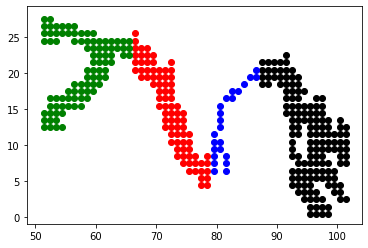

In [15]:
#----------------- Western Arabian Sea ---------------------#

lat_slice_wAS = slice(bounds_wAS[2],bounds_wAS[3]) 
lon_slice_wAS = slice(bounds_wAS[0],bounds_wAS[1]) 

#subset gridded data
temp_wAS = ds_out.temp_40_200.sel(lat = lat_slice_wAS, lon = lon_slice_wAS)
doxy_wAS = ds_out.doxy_40_200.sel(lat = lat_slice_wAS, lon = lon_slice_wAS)
nitrate_wAS = ds_out.nitrate_40_200.sel(lat = lat_slice_wAS, lon = lon_slice_wAS)
phosphate_wAS = ds_out.phosphate_40_200.sel(lat = lat_slice_wAS, lon = lon_slice_wAS)

# convert to coastal
xx,yy = np.meshgrid(np.array(temp_wAS.lon),np.array(temp_wAS.lat))
xx_wAS = xx.flatten()
yy_wAS = yy.flatten()

mask_wAS = mask_coast(xx_wAS,yy_wAS,np.array(ds_out.coastal_mask_bounds))
temp_wAS = temp_wAS.stack(allpoints=['lat','lon'])[:,mask_wAS]
doxy_wAS = doxy_wAS.stack(allpoints=['lat','lon'])[:,mask_wAS]
nitrate_wAS = nitrate_wAS.stack(allpoints=['lat','lon'])[:,mask_wAS]
phosphate_wAS = phosphate_wAS.stack(allpoints=['lat','lon'])[:,mask_wAS]
xx_wAS = xx_wAS[mask_wAS]
yy_wAS = yy_wAS[mask_wAS]

mon_wAS = np.full(temp_wAS.shape,np.nan)
lat_wAS = np.full(temp_wAS.shape,np.nan)
lon_wAS = np.full(temp_wAS.shape,np.nan)
for tt in range(1,13):
    mon_wAS[tt-1,:] = np.ones([1,temp_wAS.shape[1]])*tt
    lat_wAS[tt-1,:] = yy_wAS
    lon_wAS[tt-1,:] = xx_wAS
    
temp_wAS = np.array(temp_wAS).flatten()
doxy_wAS = np.array(doxy_wAS).flatten()
nitrate_wAS = np.array(nitrate_wAS).flatten()
phosphate_wAS = np.array(phosphate_wAS).flatten()
mon_wAS = np.array(mon_wAS).flatten()
lat_wAS = np.array(lat_wAS).flatten()
lon_wAS = np.array(lon_wAS).flatten()

# mon_wAS = mon_wAS[~np.isnan(temp_wAS)]
# lat_wAS = lat_wAS[~np.isnan(temp_wAS)]
# lon_wAS = lon_wAS[~np.isnan(temp_wAS)]
# doxy_wAS = doxy_wAS[~np.isnan(temp_wAS)]
# nitrate_wAS = nitrate_wAS[~np.isnan(temp_wAS)]
# phosphate_wAS = phosphate_wAS[~np.isnan(temp_wAS)]
# temp_wAS = temp_wAS[~np.isnan(temp_wAS)]


#----------------- Eastern Arabian Sea ---------------------#

lat_slice_eAS = slice(bounds_eAS[2],bounds_eAS[3]) 
lon_slice_eAS = slice(bounds_eAS[0],bounds_eAS[1]) 

#subset gridded data
temp_eAS = ds_out.temp_40_200.sel(lat = lat_slice_eAS, lon = lon_slice_eAS)
doxy_eAS = ds_out.doxy_40_200.sel(lat = lat_slice_eAS, lon = lon_slice_eAS)
nitrate_eAS = ds_out.nitrate_40_200.sel(lat = lat_slice_eAS, lon = lon_slice_eAS)
phosphate_eAS = ds_out.phosphate_40_200.sel(lat = lat_slice_eAS, lon = lon_slice_eAS)

# convert to coastal
xx,yy = np.meshgrid(np.array(temp_eAS.lon),np.array(temp_eAS.lat))
xx_eAS = xx.flatten()
yy_eAS = yy.flatten()

mask_eAS = mask_coast(xx_eAS,yy_eAS,np.array(ds_out.coastal_mask_bounds))
temp_eAS = temp_eAS.stack(allpoints=['lat','lon'])[:,mask_eAS]
doxy_eAS = doxy_eAS.stack(allpoints=['lat','lon'])[:,mask_eAS]
nitrate_eAS = nitrate_eAS.stack(allpoints=['lat','lon'])[:,mask_eAS]
phosphate_eAS = phosphate_eAS.stack(allpoints=['lat','lon'])[:,mask_eAS]
xx_eAS = xx_eAS[mask_eAS]
yy_eAS = yy_eAS[mask_eAS]

mon_eAS = np.full(temp_eAS.shape,np.nan)
lat_eAS = np.full(temp_eAS.shape,np.nan)
lon_eAS = np.full(temp_eAS.shape,np.nan)
for tt in range(1,13):
    mon_eAS[tt-1,:] = np.ones([1,temp_eAS.shape[1]])*tt
    lat_eAS[tt-1,:] = yy_eAS
    lon_eAS[tt-1,:] = xx_eAS
    
temp_eAS = np.array(temp_eAS).flatten()
doxy_eAS = np.array(doxy_eAS).flatten()
nitrate_eAS = np.array(nitrate_eAS).flatten()
phosphate_eAS = np.array(phosphate_eAS).flatten()
mon_eAS = np.array(mon_eAS).flatten()
lat_eAS = np.array(lat_eAS).flatten()
lon_eAS = np.array(lon_eAS).flatten()

# mon_eAS = mon_eAS[~np.isnan(temp_eAS)]
# lat_eAS = lat_eAS[~np.isnan(temp_eAS)]
# lon_eAS = lon_eAS[~np.isnan(temp_eAS)]
# doxy_eAS = doxy_eAS[~np.isnan(temp_eAS)]
# nitrate_eAS = nitrate_eAS[~np.isnan(temp_eAS)]
# phosphate_eAS = phosphate_eAS[~np.isnan(temp_eAS)]
# temp_eAS = temp_eAS[~np.isnan(temp_eAS)]

#---------------- Western Bay of Bengal --------------------#

lat_slice_wBoB = slice(bounds_wBoB[2],bounds_wBoB[3])
lon_slice_wBoB = slice(bounds_wBoB[0],bounds_wBoB[1])

#subset gridded data
temp_wBoB = ds_out.temp_40_200.sel(lat = lat_slice_wBoB, lon = lon_slice_wBoB)
doxy_wBoB = ds_out.doxy_40_200.sel(lat = lat_slice_wBoB, lon = lon_slice_wBoB)
nitrate_wBoB = ds_out.nitrate_40_200.sel(lat = lat_slice_wBoB, lon = lon_slice_wBoB)
phosphate_wBoB = ds_out.phosphate_40_200.sel(lat = lat_slice_wBoB, lon = lon_slice_wBoB)

# convert to coastal
xx,yy = np.meshgrid(np.array(temp_wBoB.lon),np.array(temp_wBoB.lat))
xx_wBoB = xx.flatten()
yy_wBoB = yy.flatten()

mask_wBoB = mask_coast_shelf(xx_wBoB,yy_wBoB,np.array(ds_out.coastal_mask_bounds))
temp_wBoB = temp_wBoB.stack(allpoints=['lat','lon'])[:,mask_wBoB]
doxy_wBoB = doxy_wBoB.stack(allpoints=['lat','lon'])[:,mask_wBoB]
nitrate_wBoB = nitrate_wBoB.stack(allpoints=['lat','lon'])[:,mask_wBoB]
phosphate_wBoB = phosphate_wBoB.stack(allpoints=['lat','lon'])[:,mask_wBoB]
xx_wBoB = xx_wBoB[mask_wBoB]
yy_wBoB = yy_wBoB[mask_wBoB]

mon_wBoB = np.full(temp_wBoB.shape,np.nan)
lat_wBoB = np.full(temp_wBoB.shape,np.nan)
lon_wBoB = np.full(temp_wBoB.shape,np.nan)
for tt in range(1,13):
    mon_wBoB[tt-1,:] = np.ones([1,temp_wBoB.shape[1]])*tt
    lat_wBoB[tt-1,:] = yy_wBoB
    lon_wBoB[tt-1,:] = xx_wBoB
    
temp_wBoB = np.array(temp_wBoB).flatten()
doxy_wBoB = np.array(doxy_wBoB).flatten()
nitrate_wBoB = np.array(nitrate_wBoB).flatten()
phosphate_wBoB = np.array(phosphate_wBoB).flatten()
mon_wBoB = np.array(mon_wBoB).flatten()
lat_wBoB = np.array(lat_wBoB).flatten()
lon_wBoB = np.array(lon_wBoB).flatten()

# mon_wBoB = mon_wBoB[~np.isnan(temp_wBoB)]
# lat_wBoB = lat_wBoB[~np.isnan(temp_wBoB)]
# lon_wBoB = lon_wBoB[~np.isnan(temp_wBoB)]
# doxy_wBoB = doxy_wBoB[~np.isnan(temp_wBoB)]
# nitrate_wBoB = nitrate_wBoB[~np.isnan(temp_wBoB)]
# phosphate_wBoB = phosphate_wBoB[~np.isnan(temp_wBoB)]
# temp_wBoB = temp_wBoB[~np.isnan(temp_wBoB)]


#---------------- Eastern Bay of Bengal --------------------#

lat_slice_eBoB = slice(bounds_eBoB[2],bounds_eBoB[3])
lon_slice_eBoB = slice(bounds_eBoB[0],bounds_eBoB[1])

#subset gridded data
temp_eBoB = ds_out.temp_40_200.sel(lat = lat_slice_eBoB, lon = lon_slice_eBoB)
doxy_eBoB = ds_out.doxy_40_200.sel(lat = lat_slice_eBoB, lon = lon_slice_eBoB)
nitrate_eBoB = ds_out.nitrate_40_200.sel(lat = lat_slice_eBoB, lon = lon_slice_eBoB)
phosphate_eBoB = ds_out.phosphate_40_200.sel(lat = lat_slice_eBoB, lon = lon_slice_eBoB)

# convert to coastal
xx,yy = np.meshgrid(np.array(temp_eBoB.lon),np.array(temp_eBoB.lat))
xx_eBoB = xx.flatten()
yy_eBoB = yy.flatten()

mask_eBoB = mask_coast(xx_eBoB,yy_eBoB,np.array(ds_out.coastal_mask_bounds))
temp_eBoB = temp_eBoB.stack(allpoints=['lat','lon'])[:,mask_eBoB]
doxy_eBoB = doxy_eBoB.stack(allpoints=['lat','lon'])[:,mask_eBoB]
nitrate_eBoB = nitrate_eBoB.stack(allpoints=['lat','lon'])[:,mask_eBoB]
phosphate_eBoB = phosphate_eBoB.stack(allpoints=['lat','lon'])[:,mask_eBoB]
xx_eBoB = xx_eBoB[mask_eBoB]
yy_eBoB = yy_eBoB[mask_eBoB]

mon_eBoB = np.full(temp_eBoB.shape,np.nan)
lat_eBoB = np.full(temp_eBoB.shape,np.nan)
lon_eBoB = np.full(temp_eBoB.shape,np.nan)
for tt in range(1,13):
    mon_eBoB[tt-1,:] = np.ones([1,temp_eBoB.shape[1]])*tt
    lat_eBoB[tt-1,:] = yy_eBoB
    lon_eBoB[tt-1,:] = xx_eBoB
        
temp_eBoB = np.array(temp_eBoB).flatten()
doxy_eBoB = np.array(doxy_eBoB).flatten()
nitrate_eBoB = np.array(nitrate_eBoB).flatten()
phosphate_eBoB = np.array(phosphate_eBoB).flatten()
mon_eBoB = np.array(mon_eBoB).flatten()
lat_eBoB = np.array(lat_eBoB).flatten()
lon_eBoB = np.array(lon_eBoB).flatten()

# mon_eBoB = mon_eBoB[~np.isnan(temp_eBoB)]
# lat_eBoB = lat_eBoB[~np.isnan(temp_eBoB)]
# lon_eBoB = lon_eBoB[~np.isnan(temp_eBoB)]
# doxy_eBoB = doxy_eBoB[~np.isnan(temp_eBoB)]
# nitrate_eBoB = nitrate_eBoB[~np.isnan(temp_eBoB)]
# phosphate_eBoB = phosphate_eBoB[~np.isnan(temp_eBoB)]
# temp_eBoB = temp_eBoB[~np.isnan(temp_eBoB)]

plt.scatter(xx_eBoB,yy_eBoB,color = 'k')
plt.scatter(xx_wBoB,yy_wBoB,color = 'b')
plt.scatter(xx_eAS,yy_eAS,color = 'r')
plt.scatter(xx_wAS,yy_wAS,color = 'g')

# Western Arabian Sea
ds_out['temp_wAS_40_200'] = xr.DataArray(temp_wAS,dims = ['month_wAS'],coords =[mon_wAS])
ds_out['doxy_wAS_40_200'] = xr.DataArray(doxy_wAS,dims = ['month_wAS'],coords =[mon_wAS])
ds_out['nitrate_wAS_40_200'] = xr.DataArray(nitrate_wAS,dims = ['month_wAS'],coords =[mon_wAS])
ds_out['phosphate_wAS_40_200'] = xr.DataArray(phosphate_wAS,dims = ['month_wAS'],coords =[mon_wAS])
# ds_out['lat_wAS_40_200'] = xr.DataArray(lat_wAS,dims = ['month_wAS'],coords =[mon_wAS])
# ds_out['lon_wAS_40_200'] = xr.DataArray(lon_wAS,dims = ['month_wAS'],coords =[mon_wAS])
# ds_out['mon_wAS_40_200'] = xr.DataArray(mon_wAS,dims = ['month_wAS'],coords =[mon_wAS])

# Eastern Arabian Sea
ds_out['temp_eAS_40_200'] = xr.DataArray(temp_eAS,dims = ['month_eAS'],coords =[mon_eAS])
ds_out['doxy_eAS_40_200'] = xr.DataArray(doxy_eAS,dims = ['month_eAS'],coords =[mon_eAS])
ds_out['nitrate_eAS_40_200'] = xr.DataArray(nitrate_eAS,dims = ['month_eAS'],coords =[mon_eAS])
ds_out['phosphate_eAS_40_200'] = xr.DataArray(phosphate_eAS,dims = ['month_eAS'],coords =[mon_eAS])
# ds_out['lat_eAS_40_200'] = xr.DataArray(lat_eAS,dims = ['month_eAS'],coords =[mon_eAS])
# ds_out['lon_eAS_40_200'] = xr.DataArray(lon_eAS,dims = ['month_eAS'],coords =[mon_eAS])
# ds_out['mon_eAS_40_200'] = xr.DataArray(mon_eAS,dims = ['month_eAS'],coords =[mon_eAS])

# Western Bay of Bengal
ds_out['temp_wBoB_40_200'] = xr.DataArray(temp_wBoB,dims = ['month_wBoB'],coords =[mon_wBoB])
ds_out['doxy_wBoB_40_200'] = xr.DataArray(doxy_wBoB,dims = ['month_wBoB'],coords =[mon_wBoB])
ds_out['nitrate_wBoB_40_200'] = xr.DataArray(nitrate_wBoB,dims = ['month_wBoB'],coords =[mon_wBoB])
ds_out['phosphate_wBoB_40_200'] = xr.DataArray(phosphate_wBoB,dims = ['month_wBoB'],coords =[mon_wBoB])
# ds_out['lat_wBoB_40_200'] = xr.DataArray(lat_wBoB,dims = ['month_wBoB'],coords =[mon_wBoB])
# ds_out['lon_wBoB_40_200'] = xr.DataArray(lon_wBoB,dims = ['month_wBoB'],coords =[mon_wBoB])
# ds_out['mon_wBoB_40_200'] = xr.DataArray(mon_wBoB,dims = ['month_wBoB'],coords =[mon_wBoB])

# Eastern Bay of Bengal
ds_out['temp_eBoB_40_200'] = xr.DataArray(temp_eBoB,dims = ['month_eBoB'],coords =[mon_eBoB])
ds_out['doxy_eBoB_40_200'] = xr.DataArray(doxy_eBoB,dims = ['month_eBoB'],coords =[mon_eBoB])
ds_out['nitrate_eBoB_40_200'] = xr.DataArray(nitrate_eBoB,dims = ['month_eBoB'],coords =[mon_eBoB])
ds_out['phosphate_eBoB_40_200'] = xr.DataArray(phosphate_eBoB,dims = ['month_eBoB'],coords =[mon_eBoB])
# ds_out['lat_eBoB_40_200'] = xr.DataArray(lat_eBoB,dims = ['month_eBoB'],coords =[mon_eBoB])
# ds_out['lon_eBoB_40_200'] = xr.DataArray(lon_eBoB,dims = ['month_eBoB'],coords =[mon_eBoB])
# ds_out['mon_eBoB_40_200'] = xr.DataArray(mon_eBoB,dims = ['month_eBoB'],coords =[mon_eBoB])



## 50-225

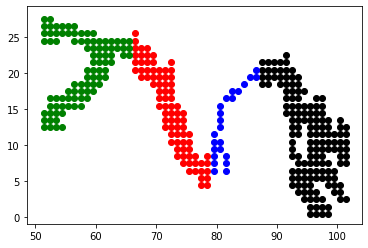

In [16]:
#----------------- Western Arabian Sea ---------------------#

lat_slice_wAS = slice(bounds_wAS[2],bounds_wAS[3]) 
lon_slice_wAS = slice(bounds_wAS[0],bounds_wAS[1]) 

#subset gridded data
temp_wAS = ds_out.temp_50_225.sel(lat = lat_slice_wAS, lon = lon_slice_wAS)
doxy_wAS = ds_out.doxy_50_225.sel(lat = lat_slice_wAS, lon = lon_slice_wAS)
nitrate_wAS = ds_out.nitrate_50_225.sel(lat = lat_slice_wAS, lon = lon_slice_wAS)
phosphate_wAS = ds_out.phosphate_50_225.sel(lat = lat_slice_wAS, lon = lon_slice_wAS)

# convert to coastal
xx,yy = np.meshgrid(np.array(temp_wAS.lon),np.array(temp_wAS.lat))
xx_wAS = xx.flatten()
yy_wAS = yy.flatten()

mask_wAS = mask_coast(xx_wAS,yy_wAS,np.array(ds_out.coastal_mask_bounds))
temp_wAS = temp_wAS.stack(allpoints=['lat','lon'])[:,mask_wAS]
doxy_wAS = doxy_wAS.stack(allpoints=['lat','lon'])[:,mask_wAS]
nitrate_wAS = nitrate_wAS.stack(allpoints=['lat','lon'])[:,mask_wAS]
phosphate_wAS = phosphate_wAS.stack(allpoints=['lat','lon'])[:,mask_wAS]
xx_wAS = xx_wAS[mask_wAS]
yy_wAS = yy_wAS[mask_wAS]

mon_wAS = np.full(temp_wAS.shape,np.nan)
lat_wAS = np.full(temp_wAS.shape,np.nan)
lon_wAS = np.full(temp_wAS.shape,np.nan)
for tt in range(1,13):
    mon_wAS[tt-1,:] = np.ones([1,temp_wAS.shape[1]])*tt
    lat_wAS[tt-1,:] = yy_wAS
    lon_wAS[tt-1,:] = xx_wAS
    
temp_wAS = np.array(temp_wAS).flatten()
doxy_wAS = np.array(doxy_wAS).flatten()
nitrate_wAS = np.array(nitrate_wAS).flatten()
phosphate_wAS = np.array(phosphate_wAS).flatten()
mon_wAS = np.array(mon_wAS).flatten()
lat_wAS = np.array(lat_wAS).flatten()
lon_wAS = np.array(lon_wAS).flatten()

# mon_wAS = mon_wAS[~np.isnan(temp_wAS)]
# lat_wAS = lat_wAS[~np.isnan(temp_wAS)]
# lon_wAS = lon_wAS[~np.isnan(temp_wAS)]
# doxy_wAS = doxy_wAS[~np.isnan(temp_wAS)]
# nitrate_wAS = nitrate_wAS[~np.isnan(temp_wAS)]
# phosphate_wAS = phosphate_wAS[~np.isnan(temp_wAS)]
# temp_wAS = temp_wAS[~np.isnan(temp_wAS)]


#----------------- Eastern Arabian Sea ---------------------#

lat_slice_eAS = slice(bounds_eAS[2],bounds_eAS[3]) 
lon_slice_eAS = slice(bounds_eAS[0],bounds_eAS[1]) 

#subset gridded data
temp_eAS = ds_out.temp_50_225.sel(lat = lat_slice_eAS, lon = lon_slice_eAS)
doxy_eAS = ds_out.doxy_50_225.sel(lat = lat_slice_eAS, lon = lon_slice_eAS)
nitrate_eAS = ds_out.nitrate_50_225.sel(lat = lat_slice_eAS, lon = lon_slice_eAS)
phosphate_eAS = ds_out.phosphate_50_225.sel(lat = lat_slice_eAS, lon = lon_slice_eAS)

# convert to coastal
xx,yy = np.meshgrid(np.array(temp_eAS.lon),np.array(temp_eAS.lat))
xx_eAS = xx.flatten()
yy_eAS = yy.flatten()

mask_eAS = mask_coast(xx_eAS,yy_eAS,np.array(ds_out.coastal_mask_bounds))
temp_eAS = temp_eAS.stack(allpoints=['lat','lon'])[:,mask_eAS]
doxy_eAS = doxy_eAS.stack(allpoints=['lat','lon'])[:,mask_eAS]
nitrate_eAS = nitrate_eAS.stack(allpoints=['lat','lon'])[:,mask_eAS]
phosphate_eAS = phosphate_eAS.stack(allpoints=['lat','lon'])[:,mask_eAS]
xx_eAS = xx_eAS[mask_eAS]
yy_eAS = yy_eAS[mask_eAS]

mon_eAS = np.full(temp_eAS.shape,np.nan)
lat_eAS = np.full(temp_eAS.shape,np.nan)
lon_eAS = np.full(temp_eAS.shape,np.nan)
for tt in range(1,13):
    mon_eAS[tt-1,:] = np.ones([1,temp_eAS.shape[1]])*tt
    lat_eAS[tt-1,:] = yy_eAS
    lon_eAS[tt-1,:] = xx_eAS
    
temp_eAS = np.array(temp_eAS).flatten()
doxy_eAS = np.array(doxy_eAS).flatten()
nitrate_eAS = np.array(nitrate_eAS).flatten()
phosphate_eAS = np.array(phosphate_eAS).flatten()
mon_eAS = np.array(mon_eAS).flatten()
lat_eAS = np.array(lat_eAS).flatten()
lon_eAS = np.array(lon_eAS).flatten()

# mon_eAS = mon_eAS[~np.isnan(temp_eAS)]
# lat_eAS = lat_eAS[~np.isnan(temp_eAS)]
# lon_eAS = lon_eAS[~np.isnan(temp_eAS)]
# doxy_eAS = doxy_eAS[~np.isnan(temp_eAS)]
# nitrate_eAS = nitrate_eAS[~np.isnan(temp_eAS)]
# phosphate_eAS = phosphate_eAS[~np.isnan(temp_eAS)]
# temp_eAS = temp_eAS[~np.isnan(temp_eAS)]

#---------------- Western Bay of Bengal --------------------#

lat_slice_wBoB = slice(bounds_wBoB[2],bounds_wBoB[3])
lon_slice_wBoB = slice(bounds_wBoB[0],bounds_wBoB[1])

#subset gridded data
temp_wBoB = ds_out.temp_50_225.sel(lat = lat_slice_wBoB, lon = lon_slice_wBoB)
doxy_wBoB = ds_out.doxy_50_225.sel(lat = lat_slice_wBoB, lon = lon_slice_wBoB)
nitrate_wBoB = ds_out.nitrate_50_225.sel(lat = lat_slice_wBoB, lon = lon_slice_wBoB)
phosphate_wBoB = ds_out.phosphate_50_225.sel(lat = lat_slice_wBoB, lon = lon_slice_wBoB)

# convert to coastal
xx,yy = np.meshgrid(np.array(temp_wBoB.lon),np.array(temp_wBoB.lat))
xx_wBoB = xx.flatten()
yy_wBoB = yy.flatten()

mask_wBoB = mask_coast_shelf(xx_wBoB,yy_wBoB,np.array(ds_out.coastal_mask_bounds))
temp_wBoB = temp_wBoB.stack(allpoints=['lat','lon'])[:,mask_wBoB]
doxy_wBoB = doxy_wBoB.stack(allpoints=['lat','lon'])[:,mask_wBoB]
nitrate_wBoB = nitrate_wBoB.stack(allpoints=['lat','lon'])[:,mask_wBoB]
phosphate_wBoB = phosphate_wBoB.stack(allpoints=['lat','lon'])[:,mask_wBoB]
xx_wBoB = xx_wBoB[mask_wBoB]
yy_wBoB = yy_wBoB[mask_wBoB]

mon_wBoB = np.full(temp_wBoB.shape,np.nan)
lat_wBoB = np.full(temp_wBoB.shape,np.nan)
lon_wBoB = np.full(temp_wBoB.shape,np.nan)
for tt in range(1,13):
    mon_wBoB[tt-1,:] = np.ones([1,temp_wBoB.shape[1]])*tt
    lat_wBoB[tt-1,:] = yy_wBoB
    lon_wBoB[tt-1,:] = xx_wBoB
    
temp_wBoB = np.array(temp_wBoB).flatten()
doxy_wBoB = np.array(doxy_wBoB).flatten()
nitrate_wBoB = np.array(nitrate_wBoB).flatten()
phosphate_wBoB = np.array(phosphate_wBoB).flatten()
mon_wBoB = np.array(mon_wBoB).flatten()
lat_wBoB = np.array(lat_wBoB).flatten()
lon_wBoB = np.array(lon_wBoB).flatten()

# mon_wBoB = mon_wBoB[~np.isnan(temp_wBoB)]
# lat_wBoB = lat_wBoB[~np.isnan(temp_wBoB)]
# lon_wBoB = lon_wBoB[~np.isnan(temp_wBoB)]
# doxy_wBoB = doxy_wBoB[~np.isnan(temp_wBoB)]
# nitrate_wBoB = nitrate_wBoB[~np.isnan(temp_wBoB)]
# phosphate_wBoB = phosphate_wBoB[~np.isnan(temp_wBoB)]
# temp_wBoB = temp_wBoB[~np.isnan(temp_wBoB)]


#---------------- Eastern Bay of Bengal --------------------#

lat_slice_eBoB = slice(bounds_eBoB[2],bounds_eBoB[3])
lon_slice_eBoB = slice(bounds_eBoB[0],bounds_eBoB[1])

#subset gridded data
temp_eBoB = ds_out.temp_50_225.sel(lat = lat_slice_eBoB, lon = lon_slice_eBoB)
doxy_eBoB = ds_out.doxy_50_225.sel(lat = lat_slice_eBoB, lon = lon_slice_eBoB)
nitrate_eBoB = ds_out.nitrate_50_225.sel(lat = lat_slice_eBoB, lon = lon_slice_eBoB)
phosphate_eBoB = ds_out.phosphate_50_225.sel(lat = lat_slice_eBoB, lon = lon_slice_eBoB)

# convert to coastal
xx,yy = np.meshgrid(np.array(temp_eBoB.lon),np.array(temp_eBoB.lat))
xx_eBoB = xx.flatten()
yy_eBoB = yy.flatten()

mask_eBoB = mask_coast(xx_eBoB,yy_eBoB,np.array(ds_out.coastal_mask_bounds))
temp_eBoB = temp_eBoB.stack(allpoints=['lat','lon'])[:,mask_eBoB]
doxy_eBoB = doxy_eBoB.stack(allpoints=['lat','lon'])[:,mask_eBoB]
nitrate_eBoB = nitrate_eBoB.stack(allpoints=['lat','lon'])[:,mask_eBoB]
phosphate_eBoB = phosphate_eBoB.stack(allpoints=['lat','lon'])[:,mask_eBoB]
xx_eBoB = xx_eBoB[mask_eBoB]
yy_eBoB = yy_eBoB[mask_eBoB]

mon_eBoB = np.full(temp_eBoB.shape,np.nan)
lat_eBoB = np.full(temp_eBoB.shape,np.nan)
lon_eBoB = np.full(temp_eBoB.shape,np.nan)
for tt in range(1,13):
    mon_eBoB[tt-1,:] = np.ones([1,temp_eBoB.shape[1]])*tt
    lat_eBoB[tt-1,:] = yy_eBoB
    lon_eBoB[tt-1,:] = xx_eBoB
        
temp_eBoB = np.array(temp_eBoB).flatten()
doxy_eBoB = np.array(doxy_eBoB).flatten()
nitrate_eBoB = np.array(nitrate_eBoB).flatten()
phosphate_eBoB = np.array(phosphate_eBoB).flatten()
mon_eBoB = np.array(mon_eBoB).flatten()
lat_eBoB = np.array(lat_eBoB).flatten()
lon_eBoB = np.array(lon_eBoB).flatten()

# mon_eBoB = mon_eBoB[~np.isnan(temp_eBoB)]
# lat_eBoB = lat_eBoB[~np.isnan(temp_eBoB)]
# lon_eBoB = lon_eBoB[~np.isnan(temp_eBoB)]
# doxy_eBoB = doxy_eBoB[~np.isnan(temp_eBoB)]
# nitrate_eBoB = nitrate_eBoB[~np.isnan(temp_eBoB)]
# phosphate_eBoB = phosphate_eBoB[~np.isnan(temp_eBoB)]
# temp_eBoB = temp_eBoB[~np.isnan(temp_eBoB)]

plt.scatter(xx_eBoB,yy_eBoB,color = 'k')
plt.scatter(xx_wBoB,yy_wBoB,color = 'b')
plt.scatter(xx_eAS,yy_eAS,color = 'r')
plt.scatter(xx_wAS,yy_wAS,color = 'g')

# Western Arabian Sea
ds_out['temp_wAS_50_225'] = xr.DataArray(temp_wAS,dims = ['month_wAS'],coords =[mon_wAS])
ds_out['doxy_wAS_50_225'] = xr.DataArray(doxy_wAS,dims = ['month_wAS'],coords =[mon_wAS])
ds_out['nitrate_wAS_50_225'] = xr.DataArray(nitrate_wAS,dims = ['month_wAS'],coords =[mon_wAS])
ds_out['phosphate_wAS_50_2025'] = xr.DataArray(phosphate_wAS,dims = ['month_wAS'],coords =[mon_wAS])
# ds_out['lat_wAS_50_225'] = xr.DataArray(lat_wAS,dims = ['month_wAS'],coords =[mon_wAS])
# ds_out['lon_wAS_50_225'] = xr.DataArray(lon_wAS,dims = ['month_wAS'],coords =[mon_wAS])
# ds_out['mon_wAS_50_225'] = xr.DataArray(mon_wAS,dims = ['month_wAS'],coords =[mon_wAS])

# Eastern Arabian Sea
ds_out['temp_eAS_50_225'] = xr.DataArray(temp_eAS,dims = ['month_eAS'],coords =[mon_eAS])
ds_out['doxy_eAS_50_225'] = xr.DataArray(doxy_eAS,dims = ['month_eAS'],coords =[mon_eAS])
ds_out['nitrate_eAS_50_225'] = xr.DataArray(nitrate_eAS,dims = ['month_eAS'],coords =[mon_eAS])
ds_out['phosphate_eAS_50_225'] = xr.DataArray(phosphate_eAS,dims = ['month_eAS'],coords =[mon_eAS])
# ds_out['lat_eAS_50_225'] = xr.DataArray(lat_eAS,dims = ['month_eAS'],coords =[mon_eAS])
# ds_out['lon_eAS_50_225'] = xr.DataArray(lon_eAS,dims = ['month_eAS'],coords =[mon_eAS])
# ds_out['mon_eAS_50_225'] = xr.DataArray(mon_eAS,dims = ['month_eAS'],coords =[mon_eAS])

# Western Bay of Bengal
ds_out['temp_wBoB_50_225'] = xr.DataArray(temp_wBoB,dims = ['month_wBoB'],coords =[mon_wBoB])
ds_out['doxy_wBoB_50_225'] = xr.DataArray(doxy_wBoB,dims = ['month_wBoB'],coords =[mon_wBoB])
ds_out['nitrate_wBoB_50_225'] = xr.DataArray(nitrate_wBoB,dims = ['month_wBoB'],coords =[mon_wBoB])
ds_out['phosphate_wBoB_50_225'] = xr.DataArray(phosphate_wBoB,dims = ['month_wBoB'],coords =[mon_wBoB])
# ds_out['lat_wBoB_50_225'] = xr.DataArray(lat_wBoB,dims = ['month_wBoB'],coords =[mon_wBoB])
# ds_out['lon_wBoB_50_225'] = xr.DataArray(lon_wBoB,dims = ['month_wBoB'],coords =[mon_wBoB])
# ds_out['mon_wBoB_50_225'] = xr.DataArray(mon_wBoB,dims = ['month_wBoB'],coords =[mon_wBoB])

# Eastern Bay of Bengal
ds_out['temp_eBoB_50_225'] = xr.DataArray(temp_eBoB,dims = ['month_eBoB'],coords =[mon_eBoB])
ds_out['doxy_eBoB_50_225'] = xr.DataArray(doxy_eBoB,dims = ['month_eBoB'],coords =[mon_eBoB])
ds_out['nitrate_eBoB_50_225'] = xr.DataArray(nitrate_eBoB,dims = ['month_eBoB'],coords =[mon_eBoB])
ds_out['phosphate_eBoB_50_225'] = xr.DataArray(phosphate_eBoB,dims = ['month_eBoB'],coords =[mon_eBoB])
# ds_out['lat_eBoB_50_225'] = xr.DataArray(lat_eBoB,dims = ['month_eBoB'],coords =[mon_eBoB])
# ds_out['lon_eBoB_50_225'] = xr.DataArray(lon_eBoB,dims = ['month_eBoB'],coords =[mon_eBoB])
# ds_out['mon_eBoB_50_225'] = xr.DataArray(mon_eBoB,dims = ['month_eBoB'],coords =[mon_eBoB])



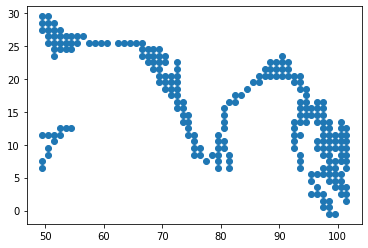

In [17]:
plt.scatter(mask_xxs,mask_yys)

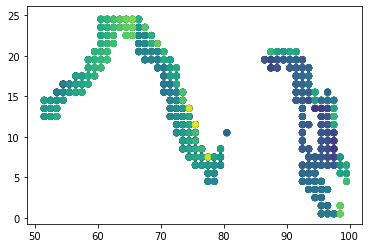

In [28]:
plt.scatter(lon_eBoB,lat_eBoB,c = temp_eBoB)
plt.scatter(lon_wBoB,lat_wBoB,c = temp_wBoB)
plt.scatter(lon_eAS,lat_eAS,c = temp_eAS)
plt.scatter(lon_wAS,lat_wAS,c = temp_wAS)

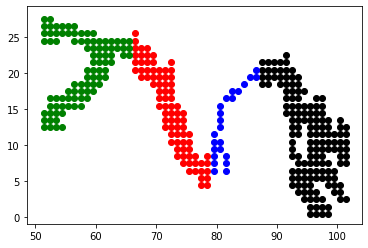

In [26]:
plt.scatter(xx_eBoB,yy_eBoB,color = 'k')
plt.scatter(xx_wBoB,yy_wBoB,color = 'b')
plt.scatter(xx_eAS,yy_eAS,color = 'r')
plt.scatter(xx_wAS,yy_wAS,color = 'g')

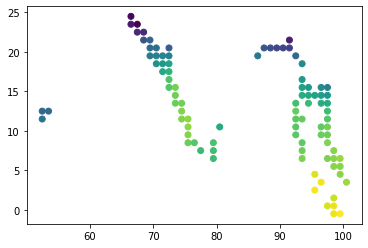

In [31]:
xx,yy = np.meshgrid(ds_out.lon,ds_out.lat)
plt.scatter(xx.flatten()[masks],yy.flatten()[masks], c = np.array(ds_out.temp[0,0,:,:]).flatten()[masks])

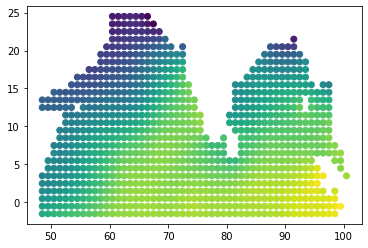

In [32]:
xx,yy = np.meshgrid(ds_out.lon,ds_out.lat)
plt.scatter(xx.flatten(),yy.flatten(), c = np.array(ds_out.temp[0,0,:,:]).flatten())

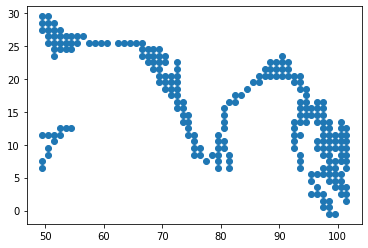

In [33]:
xx,yy = np.meshgrid(ds_out.lon,ds_out.lat)
plt.scatter(mask_xxs,mask_yys)

# SAVE

In [29]:
# delete if already present
if os.path.isfile(outfn):
    os.remove(outfn)

ds_out.to_netcdf(outfn,mode='w',format = "NETCDF4")